<a href="https://colab.research.google.com/github/ravindrabharathi/Project1/blob/master/Rgroup2/4_oct_Ravindra_EVA_research_grp2_test_distortion_in_mid_lower_layers_DavidNet_60_epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install tf2 modules 

### install/import tensorflow_addons

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow==2.0
!pip install tensorflow-gpu==2.0
!pip install tensorflow_addons
import tensorflow as tf
import tensorflow_addons as tfa
import math
import random

     |████████████████████████████████| 86.3MB 35.3MB/s 
     |████████████████████████████████| 450kB 42.2MB/s 
     |████████████████████████████████| 3.8MB 36.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=6e22927ccf5650edc68635d04ecc6888b9236ebb8b13b716a4a5911e29f4fd0d
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.2
    Uninstalling gast-0.3.2:
      Successfully uninstalled gast-0.3.2
  Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tensorflow-estimator-1.14.0
  Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0
     |

### Install tf_utils

In [0]:
!pip install --upgrade git+https://github.com/ravindrabharathi/tf_utils 

  Cloning https://github.com/ravindrabharathi/tf_utils to /tmp/pip-req-build-s0ejlgnr
  Running command git clone -q https://github.com/ravindrabharathi/tf_utils /tmp/pip-req-build-s0ejlgnr
  Created wheel for tf-utils: filename=tf_utils-0.2-cp36-none-any.whl size=8945 sha256=c25a6d02f35737de35b04aac2bebf8c4e5bfaa9720b1dc4f157cb7a38cc86a2d
  Stored in directory: /tmp/pip-ephem-wheel-cache-qveeyhdf/wheels/95/af/bb/690b94c65a5aad47a5c39e75f158a2b043448e908c5c121791
Successfully built tf-utils


### import the data module

In [0]:
import tf_utils.data as ds

Finished 'get_cpu_num' in 0.0000 secs


### set batch size

In [0]:
batch_size=512
ds.batch_size=batch_size
EPOCHS=60

### downlaod data and create tf records

In [0]:
ds.get_cifar10_and_create_tfrecords()


Finished 'download_file' in 6.5949 secs
Finished 'download_cifar10_files' in 6.5955 secs
Done
Finished 'extract_cifar10_files' in 1.8980 secs
Finished '_get_file_names' in 0.0000 secs
Generating ./train.tfrecords
Finished 'read_pickle_from_file' in 0.1492 secs
Finished 'read_pickle_from_file' in 0.1437 secs
Finished 'read_pickle_from_file' in 0.1336 secs
Finished 'read_pickle_from_file' in 0.1461 secs
Finished 'read_pickle_from_file' in 0.1339 secs
Finished 'convert_to_tfrecord' in 3.1494 secs
Done!
Generating ./eval.tfrecords
Finished 'read_pickle_from_file' in 0.1379 secs
Finished 'convert_to_tfrecord' in 0.6191 secs
Done!
Finished 'create_tf_records' in 3.7707 secs
Finished 'get_cifar10_and_create_tfrecords' in 12.2647 secs


### create train and test dataset

In [0]:
def aug_fn(image):
  return ds.cutout(ds.flip_left_right(ds.random_pad_crop(image)))

train_ds1=ds.get_train_ds(batch_size=batch_size,shuffle=True,distort=True,distort_fn=aug_fn)
train_ds2=ds.get_train_ds(batch_size=batch_size,shuffle=True,distort=False)

test_ds=ds.get_eval_ds(batch_size=batch_size)

distorting...
Finished 'get_tf_dataset_2' in 2.7414 secs
Finished 'get_tf_dataset_in_batches' in 2.7418 secs
Finished 'get_train_ds' in 2.7420 secs
Finished 'get_tf_dataset' in 0.1619 secs
Finished 'get_tf_dataset_in_batches' in 0.1621 secs
Finished 'get_train_ds' in 0.1625 secs
Finished 'get_tf_dataset' in 0.0262 secs
Finished 'get_tf_dataset_in_batches' in 0.0263 secs
Finished 'get_eval_ds' in 0.0264 secs


### import visualization module

In [0]:
import tf_utils.visualize as vz

### plot images from train dataset1 , train dataset by default uses image augmenttation of cutout,flip-left-right,random-pad-crop 

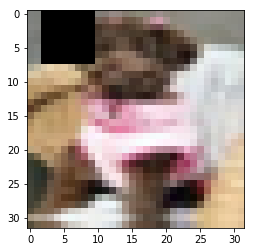

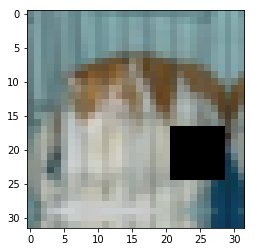

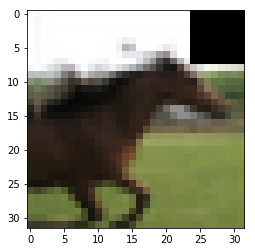

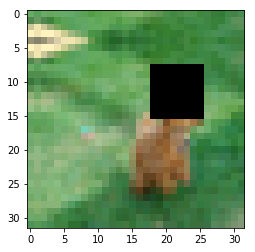

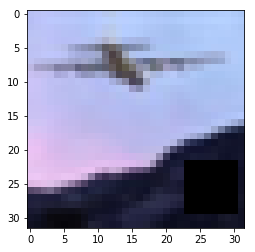

In [0]:
vz.plot_cifar10_files(train_ds1)

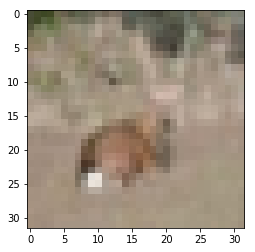

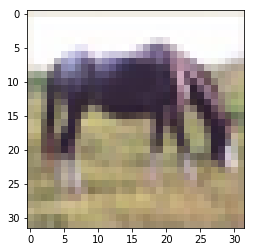

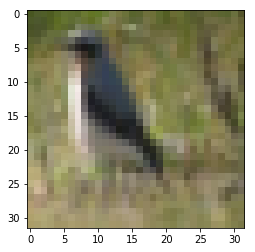

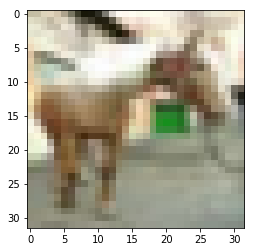

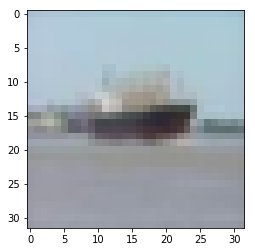

In [0]:
vz.plot_cifar10_files(train_ds2)

### Training - Build model , compile and train 

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D,  Activation, GlobalMaxPooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization , Dense, Lambda

from tensorflow.keras.optimizers import Adam,SGD

import numpy as np
import math
WEIGHT_DECAY=1.25e-4
reg=tf.keras.regularizers.l2(WEIGHT_DECAY)
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

def conv(inp,f=32,k=3):
  conv_layer=Conv2D(f,k,use_bias=False,padding='same',kernel_initializer=init_pytorch, kernel_regularizer=reg)(inp)
  conv_layer=BatchNormalization(momentum=0.9, epsilon=1e-5)(conv_layer)
  conv_layer=Activation('relu')(conv_layer)
  return conv_layer
def resBlk(inp,f=32,k=3,residual=True) :
  res1=conv(inp,f,k)
  res1=MaxPooling2D(pool_size=(2,2))(res1)
  if residual:
    res2=conv(res1,f,k)
    res3=conv(res2,f,k)
    return res1+res3
  else:
    return res1  

def apply_weight(x):
  return x*0.125  

def random_pad_crop(image,padding=2):
  shp=tf.shape(image)
  
  image=tf.pad(image,[(0, 0), (padding, padding), (padding, padding), (0, 0)], mode='reflect')
  
  image=tf.image.random_crop(image,size=shp)
  return image  

def flip_left_right(image):
  return tf.image.random_flip_left_right(image)   

def aug_fn1(img):
  shp=img.get_shape()
  #print(shp)
  #out_shp=[shp[0],shp[1],shp[2]]
  return ds.flip_left_right(ds.random_crop(ds.cutout(ds.pad_img(img,padding=2),100,size=4),out_shape=shp))

def aug_fn2(img):
  shp=img.get_shape()
  #print(shp)
  #out_shp=[shp[0],shp[1],shp[2]]
  return ds.flip_left_right(ds.random_crop(ds.cutout(ds.pad_img(img,padding=1),100,size=2),out_shape=shp))

def aug1(image):
  print('is_training',is_training)
  if is_training:
    
    #return tf.map_fn(lambda img: aug_fn1(img),image,parallel_iterations=ds.CPU_CORES,back_prop=is_training) 
    return tf.map_fn(lambda img: aug_fn1(img) ,image,back_prop=is_training)    
  else:
    print('inside validation cycle\n===============\n')
    return image  

def aug2(image):
  
  print('is_training',is_training)
  if is_training:
    
    return tf.map_fn(lambda img: aug_fn2(img) ,image,back_prop=is_training)
  else:
    print('inside validation cycle\n===============\n')
    return image        

In [0]:
def build_model(distort_param=0):
  f=64
  inp=Input(shape=(32,32,3))
  layer1=conv(inp,f,3)
  res1=resBlk(layer1,f*2,3)
  if (distort_param in [1,3,4]):
    res1=Lambda(aug1)(res1)
  res2=resBlk(res1,f*4,3,False)
  if (distort_param in [2,3,5]):
    res2=Lambda(aug2)(res2)
  res3=resBlk(res2,f*8,3)
  
  layer2=GlobalMaxPooling2D()(res3)
  layer3=Dense(10, kernel_initializer=init_pytorch, use_bias=False,kernel_regularizer=reg)(layer2)
  layer4=Lambda(lambda x: x*0.125)(layer3)
  out=Activation('softmax')(layer4)
  model=Model(inputs=[inp],outputs=[out])
  model.summary()
  return model 

In [0]:

from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule():
    
    def schedule(epoch):

      lr=lr1=np.interp([epoch],[0, EPOCHS//3,EPOCHS], [0.025, 0.4, 0])[0]
      print('epoch ', epoch+1, ': setting learning rate to ',lr1)
      return lr
    
    return LearningRateScheduler(schedule)

lr_sched = lr_schedule()


In [0]:

for model_params in [5,4,3,2,1,0]:
  is_training=True
  #global_step = tf.train.get_or_create_global_step()
  model=model=build_model(model_params)
  opt=SGD(lr=0.025,momentum=0.9,nesterov=True)
  model.compile(loss='categorical_crossentropy',
              optimizer=opt,metrics=['accuracy']
              )
  batch_size=512
  
  if model_params in [0,4,5]:
    train_ds=train_ds1
    print('Model will be trained with image augmentation in put layer\n====================')
    if model_params==4:
      print('Model will also include distortion after Res Blk 1\n=======================')
    elif model_params==5:
      print('Model will also include distortion after Res Blk 2\n=======================')
      
  else:
    if model_params==1:
      print('Model will be trained with distortion after Res Blk 1\n=======================')
    elif model_params==2:
      print('Model will be trained with distortion after Res Blk 2\n=======================')
    elif model_params==3:
      print('Model will be trained with distortion after Res Blk 1 and Res Blk 2\n=======================')    
    train_ds=train_ds2  
  model.fit(train_ds,epochs=EPOCHS, steps_per_epoch=np.ceil(50000/batch_size), 
          callbacks=[lr_sched],
          verbose=1)
  is_training=False
  score=model.evaluate(test_ds, steps =np.ceil(10000/batch_size), verbose=1)

  del(model)
  del(train_ds)
  
  print('val accuracy score at the end of training model type ',model_params, score)
  print("=========================================\n")

#validation_data=test_ds, validation_steps=np.ceil(10000/batch_size),

is_training True
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
_____________________________________________________________________________

### Runtime disconnected . So we will run the interrupted test combinations again - only the ones that were missed out

In [0]:

for model_params in [0,1,2]:
  is_training=True
  #global_step = tf.train.get_or_create_global_step()
  model=model=build_model(model_params)
  opt=SGD(lr=0.025,momentum=0.9,nesterov=True)
  model.compile(loss='categorical_crossentropy',
              optimizer=opt,metrics=['accuracy']
              )
  batch_size=512
  
  if model_params in [0,4,5]:
    train_ds=train_ds1
    print('Model will be trained with image augmentation in put layer\n====================')
    if model_params==4:
      print('Model will also include distortion after Res Blk 1\n=======================')
    elif model_params==5:
      print('Model will also include distortion after Res Blk 2\n=======================')
      
  else:
    if model_params==1:
      print('Model will be trained with distortion after Res Blk 1\n=======================')
    elif model_params==2:
      print('Model will be trained with distortion after Res Blk 2\n=======================')
    elif model_params==3:
      print('Model will be trained with distortion after Res Blk 1 and Res Blk 2\n=======================')    
    train_ds=train_ds2  
  model.fit(train_ds,epochs=EPOCHS, steps_per_epoch=np.ceil(50000/batch_size), 
          callbacks=[lr_sched],
          verbose=1)
  is_training=False
  score=model.evaluate(test_ds, steps =np.ceil(10000/batch_size), verbose=1)

  del(model)
  del(train_ds)
  
  print('val accuracy score at the end of training model type ',model_params, score)
  print("=========================================\n")

#validation_data=test_ds, validation_steps=np.ceil(10000/batch_size),

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Summary of Test Results 
Hyperparameters : Epochs:60, max_lr:0.4, momentum:0.9, L2-wt_decay on Conv Layers :1.25e-4 

| Trial | Augmentation strategy | Train accuracy |Test Accuracy | Hyperparameters |Comments |
| :--- | :---: | :---: | :---: | :---: | :--- |
| 1 | cutout(flip_lr(pad4_random_crop(inp_image),8)  |99.62  | 94.44 | as above | train-test acc gap 5.18 |
| 2 | flip_lr(random_crop(cutout(pad2(res_blk1),4)))  |99.98  | 92.36 | " | Lower Val accuracy , Tendency to overfit . Perhaps try a more stringent Aug policy ? |
| 3 | flip_lr(random_crop(cutout(pad2(res_blk1),4)))  | 99.98 | 91.18 | " | Lower Val Accuracy, Tendency to overfit.  |
| 4 | augmentation of trial 2 + augmentation of trial 3  | 99.92  | 92.40 | " | Lower Val Accuracy, Tendency to overfit.  |
| 5 | augmentations of trial 1 + augmentation of trial 2  | 99.04  | 94.41 |"| train-test acc gap 4.63 |
| 6 | augmentations of trial 1 + augmentation of trial 3  | 98.96 | **94.72** |"| Train-Test acc gap : 4.24 |

**Validation accuracy went down when only Distortion was used in the mid/lower layers (after Res Blk1 and Res Blk2 ) But when used in combination with usual Image augmentation , there seems to be better Regularization and perhaps we could explore such an option. If we were to pursue only Distortion of middle or lower layers (with a good enough size of channels ) , we may need to try more stringent augmentation strategies to overcome the problem of overfitting**